In [1]:
import numpy as np
import model

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.utils import R_lasso
from mrashpen.utils import R_trendfilter
from gradvi.inference import LinearRegression
from gradvi.normal_means import NormalMeansFromPosterior
from gradvi.tests import toy_priors

Signal-to-noise ratio: 0.009


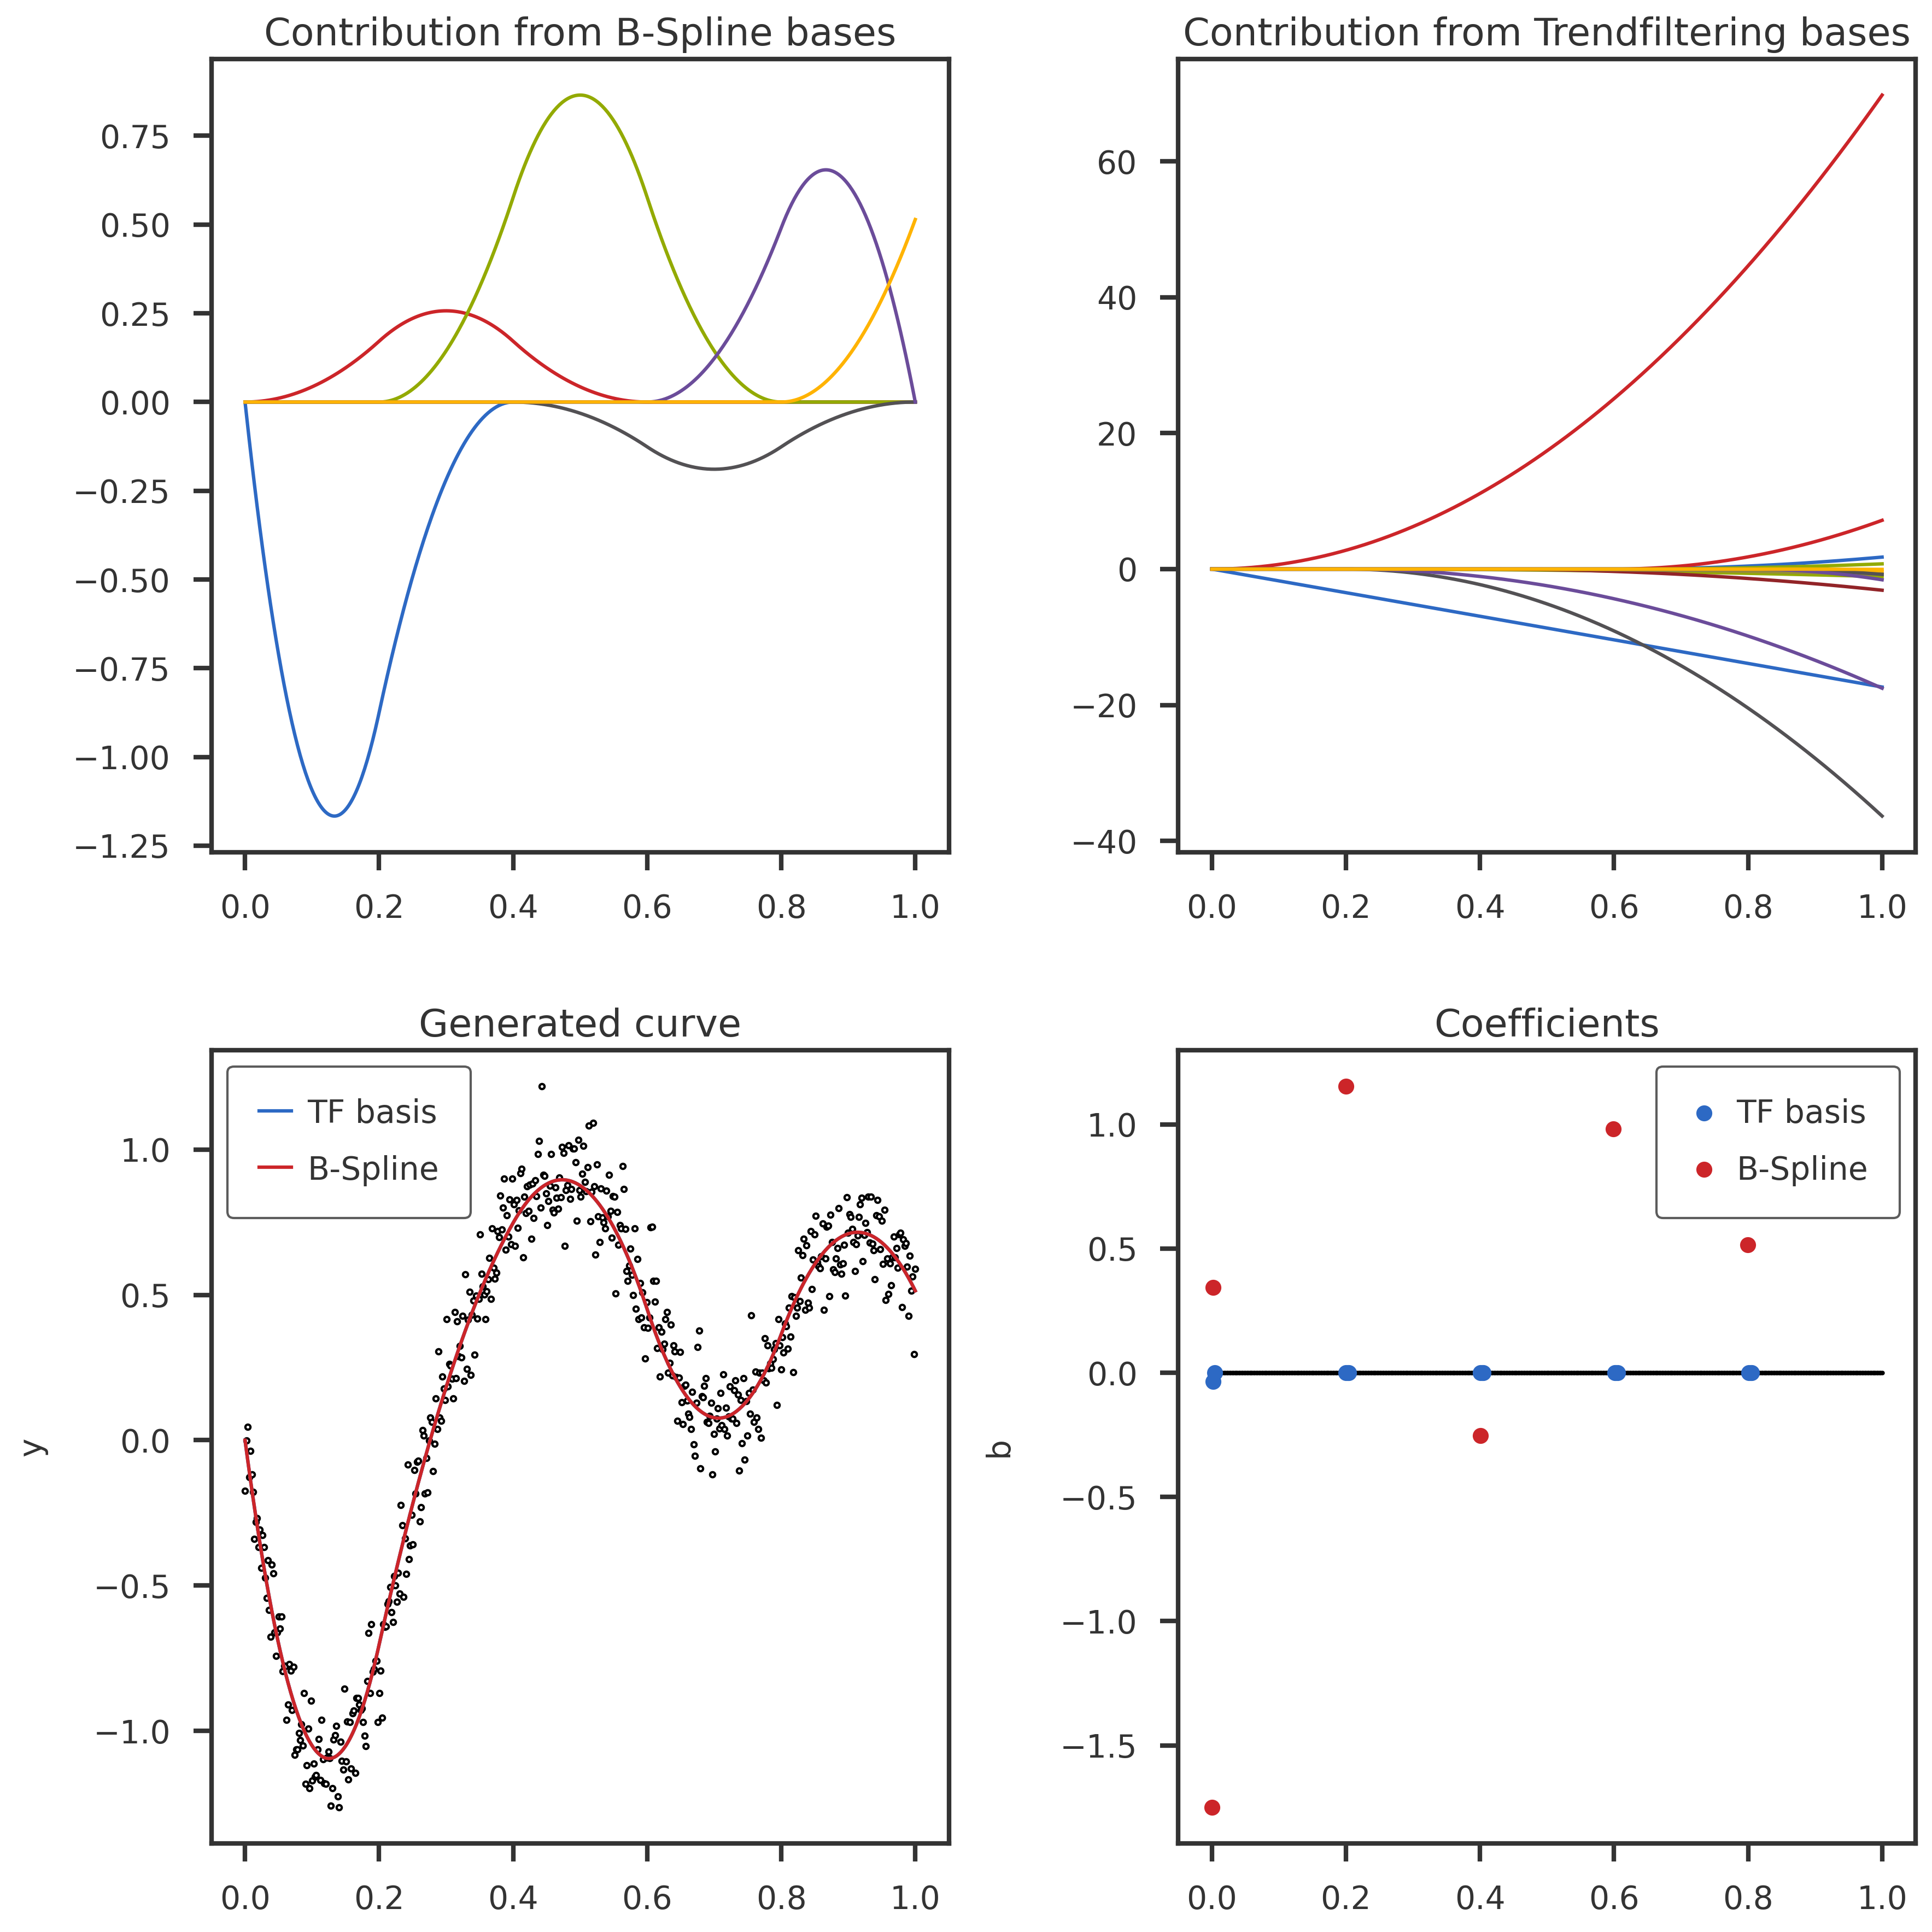

In [2]:
n = 500
x = np.linspace(0, 1, n)
np.random.seed(100)

# Zeroth degree trendfiltering
nknots = 4
degree = 2
strue = 0.1
include_intercept = False
knots = np.linspace(0, 1, nknots+2)[1:-1]
bfix = np.random.normal(0, 1, size = nknots + degree)

H, y, ytest, btrue, snr, G, Gb = model.changepoint_from_bspline(x, knots, strue,
                                            degree = degree, 
                                            signal = "fixed", bfix = bfix,
                                            seed = 100, include_intercept = include_intercept,
                                            get_bsplines = True, eps = 1e-8
                                           )
print(f"Signal-to-noise ratio: {snr:.3f}")

fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, H, btrue, show_base_legend = False)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

In [3]:
Hinv = model.trendfiltering_basis_matrix_inverse(n, degree)

In [4]:
ytrue = np.dot(H, btrue)
np.allclose(btrue, np.dot(Hinv, ytrue))

True

In [5]:
tf_y, tf_fit = R_trendfilter.fit(y, order = degree)
tf_bhat  = np.dot(Hinv, tf_y)

R[write to console]: Loading required package: Matrix



Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [6]:
np.allclose(tf_y, np.dot(H, tf_bhat))

True

In [7]:
# def center_and_scale_tfbasis(Z, b):
#     '''
#     Basis matrix Z is always 2D.
#     b is the coefficient vector
#     The first column of Z is all 1, hence it has zero standard deviation.
#     '''
#     dim  = Z.ndim
#     std  = np.std(Z, axis = 0)
#     skip = 0
#     if std[0] == 0:
#         # do not scale the first column
#         print ("The first column has all equal values.")
#         std[0] = 1.0
#         skip = 1
#     Znew = Z / std
#     colmeans = np.mean(Znew[:, skip:], axis = 0)
#     Znew[:, skip:] = Znew[:, skip:] - colmeans.reshape(1, -1)
#     bnew = b * std
#     ## add the intercept
#     if skip == 1:
#         bnew[0] += np.sum(colmeans * std[1:] * b[1:])
#     '''
#     alternative
#     bnew = np.dot(np.dot(np.linalg.inv(Znew), Z), b)
#     '''
#     return Znew, bnew

# Hscale, bscale = center_and_scale_tfbasis(H, btrue)
# _, tf_bscale   = center_and_scale_tfbasis(H, tf_bhat)
# dj = np.sum(np.square(Hscale), axis = 0)
# print (dj)

In [8]:
'''
GradVI Trendfiltering
'''
def fun1(params, y, A, prior, sj2, s2, dj, jac = True):
    n = y.shape[0]
    k = prior.k
    x = params[:n]
    a = params[n:]
    prior.update_wmod(a)
    
    r = y - x
    rTr = np.dot(r, r)
    
    #sj2 = s2 / dj
    b = np.dot(A, x)
    nm = NormalMeansFromPosterior(b, prior, sj2, scale = s2, d = dj, method = 'newton')
    Pb, dPdb, dPdw, dPds2 = nm.penalty_operator(jac = True)
    
    h = (0.5 * rTr / s2) + np.sum(Pb)
    #h = np.sum(Pb)
    if jac:
        dhdx = - r / s2 + np.dot(A.T, dPdb)
        #dhdx = np.dot(A.T, dPdb)
        dhdw  = np.sum(dPdw, axis = 0)
        dhda  = prior.wmod_grad(dhdw)
        return h, np.concatenate((dhdx, dhda))
    return h

def fun2(x, A, prior, sj2, s2, dj, jac = True):
    y = np.dot(A, x)
    nm = NormalMeansFromPosterior(y, prior, sj2, scale = s2, d = dj, method = 'newton')
    hj, dhdy, _, _ = nm.penalty_operator(jac = True)
    h = np.sum(hj)
    if jac:
        dhdx = np.dot(A.T, dhdy)
        return h, dhdx
    return h

In [9]:
prior = toy_priors.get_ash_scaled(k = 10, sparsity = None, skbase = 2)

dj = np.sum(np.square(H), axis = 0)
s2 = np.var(y - tf_y)
sj2 = s2 / dj
mu = tf_y.copy()
#obj, dhdmu = fun2(mu, Hinv, prior, sj2, s2, dj, jac = True)
#obj, dhdmu = fun1(mu, y, Hinv, prior, sj2, s2, dj, jac = True)

In [10]:
vars(prior)

{'smbase': 2.718281828459045,
 'sk': array([0.        , 0.07177346, 0.14869835, 0.23114441, 0.31950791,
        0.41421356, 0.51571657, 0.62450479, 0.74110113, 0.86606598]),
 'w': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 'wmod': array([-2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499,
        -2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499]),
 'w_init': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 'wmod_init': array([-2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499,
        -2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499]),
 'is_scaled': True,
 'normal_means': gradvi.normal_means.nm_ash_scaled.NMAshScaled}

In [11]:
from scipy import optimize as sp_optimize

initparams = np.concatenate((tf_y, prior.wmod_init))
opt_min = sp_optimize.minimize(
        fun1, 
        initparams,
        args = (y, Hinv, prior, sj2, s2, dj),
        method = 'l-bfgs-b', 
        jac = True,
        #options = {'disp': True, 'maxiter': 10, 'return_all': True}
        options = {'disp':True, 'maxiter': 1000, 'tol': 1e-8}
        )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          510     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.99925D+03    |proj g|=  7.95514D+07
2022-04-22 21:29:44,542 | gradvi.normal_means.nm_from_posterior | ERROR | Failed to invert the posterior mean for Normal Means model with newton
2022-04-22 21:29:44,542 | gradvi.normal_means.nm_from_posterior | ERROR | !!!=== OVERRIDING USER CHOICE ===!!!
2022-04-22 21:29:44,543 | gradvi.normal_means.nm_from_posterior | ERROR | Using Powell's method for inverting posterior mean.


/tmp/ipykernel_123090/4107314306.py:4: OptimizeWarning: Unknown solver options: tol
  opt_min = sp_optimize.minimize(
 This problem is unconstrained.


2022-04-22 21:29:45,135 | gradvi.normal_means.nm_from_posterior | ERROR | Failed to invert the posterior mean for Normal Means model with newton
2022-04-22 21:29:45,135 | gradvi.normal_means.nm_from_posterior | ERROR | !!!=== OVERRIDING USER CHOICE ===!!!
2022-04-22 21:29:45,136 | gradvi.normal_means.nm_from_posterior | ERROR | Using Powell's method for inverting posterior mean.
2022-04-22 21:29:45,752 | gradvi.normal_means.nm_from_posterior | ERROR | Failed to invert the posterior mean for Normal Means model with newton
2022-04-22 21:29:45,752 | gradvi.normal_means.nm_from_posterior | ERROR | !!!=== OVERRIDING USER CHOICE ===!!!
2022-04-22 21:29:45,753 | gradvi.normal_means.nm_from_posterior | ERROR | Using Powell's method for inverting posterior mean.
2022-04-22 21:29:46,331 | gradvi.normal_means.nm_from_posterior | ERROR | Failed to invert the posterior mean for Normal Means model with newton
2022-04-22 21:29:46,332 | gradvi.normal_means.nm_from_posterior | ERROR | !!!=== OVERRIDING


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    3    f= -4.99930D+03    |proj g|=  1.53860D+08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  510      3     37      1     0     0   1.539D+08  -4.999D+03
  F =  -4999.2993603216937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [12]:
vars(prior)

{'smbase': 2.718281828459045,
 'sk': array([0.        , 0.07177346, 0.14869835, 0.23114441, 0.31950791,
        0.41421356, 0.51571657, 0.62450479, 0.74110113, 0.86606598]),
 'w': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 'wmod': array([-2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499,
        -2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499]),
 'w_init': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 'wmod_init': array([-2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499,
        -2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499]),
 'is_scaled': True,
 'normal_means': gradvi.normal_means.nm_ash_scaled.NMAshScaled}

In [13]:
bhat = opt_min.x[:mu.shape[0]]

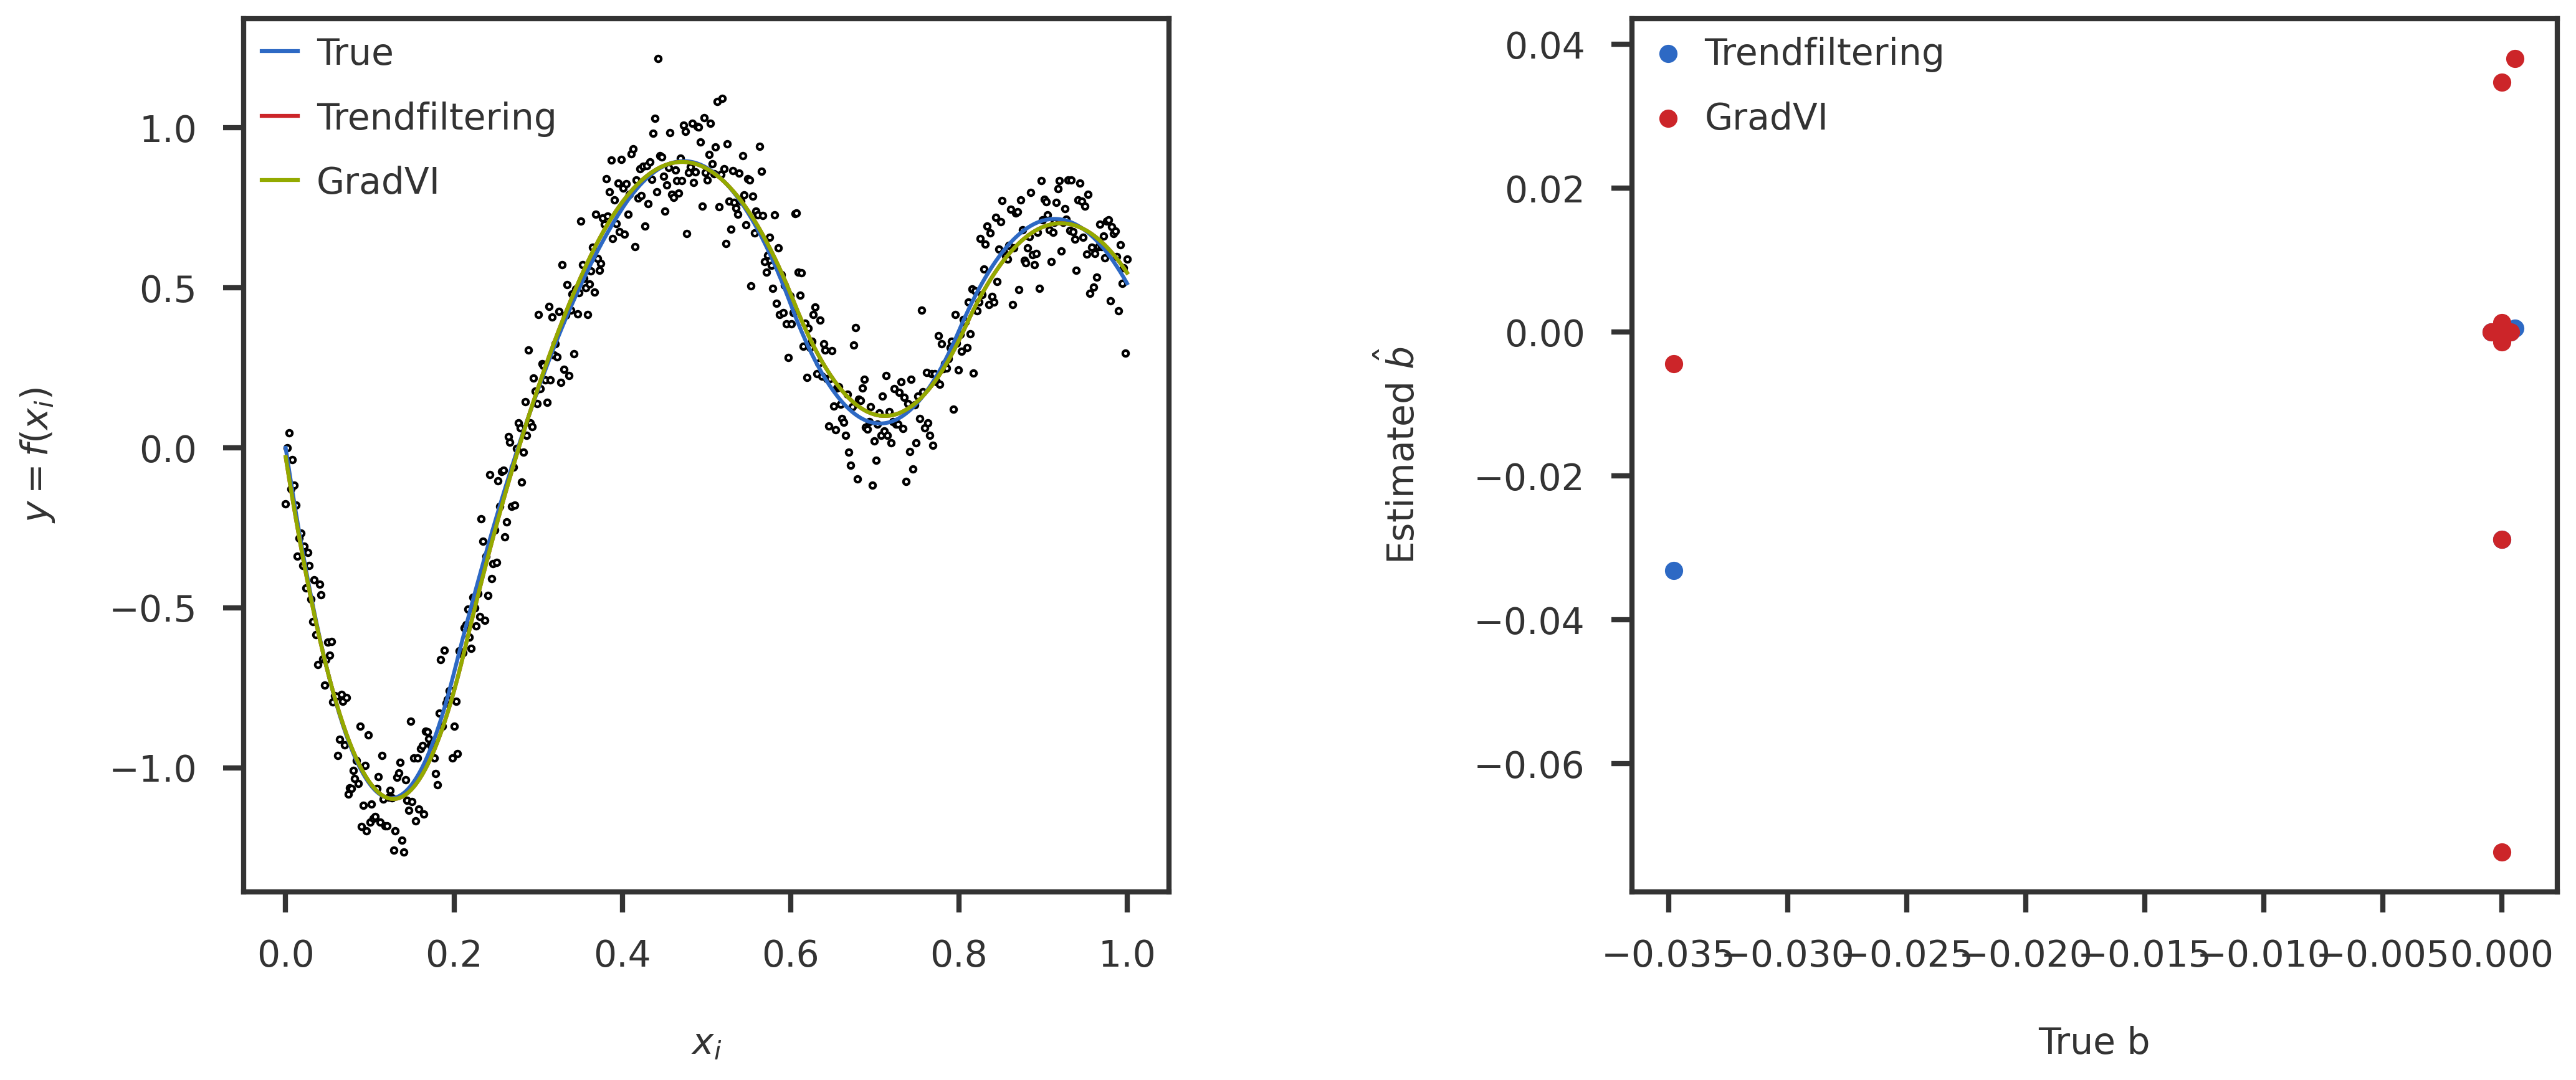

In [14]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(x, y, s = 5, edgecolor = 'black', facecolor='white')
ax1.plot(x, np.dot(H, btrue), label = "True")
ax1.plot(x, tf_y, label = "Trendfiltering")
ax1.plot(x, bhat, label = "GradVI")
ax1.legend()

ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")
ax2.scatter(btrue, tf_bhat, label = "Trendfiltering")
ax2.scatter(btrue, np.dot(Hinv, tf_bhat), label = "GradVI")

ax2.set_xlabel("True b")
ax2.set_ylabel(r"Estimated $\hat{b}$")
ax2.legend()
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

In [15]:
# def numerical_derivative2(fn, a, y, D, prior, sj2, s2, dj, eps = 1e-4):
#     n = a.shape[0]
#     dfdx = np.zeros(n)
#     h = fn(a, y, D, prior, sj2, s2, dj, jac = False)
#     for i in range(n):
#         a_eps     = a.copy()
#         a_eps[i] += eps
#         h_eps1    = fn(a_eps, y, D, prior, sj2, s2, dj, jac = False)
#         a_eps[i] -= 2 * eps
#         h_eps2    = fn(a_eps, y, D, prior, sj2, s2, dj, jac = False)
#         dfdx[i]   = (h_eps1 - h_eps2) / (2 * eps)
#     return dfdx

# d_numeric = numerical_derivative2(fun1, mu, y, Hinv, prior, sj2, s2, dj)

In [16]:
# np.allclose(dhdmu, d_numeric, atol = 1e-2, rtol = 1e-8)

In [17]:
# dhdmu[np.argmax(np.abs(dhdmu - d_numeric))]

In [18]:
# d_numeric[np.argmax(np.abs(dhdmu - d_numeric))]